In [1]:
from sklearn.cluster import KMeans
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
import json
import scipy.sparse as sparse
from collections import defaultdict
from utils import  *
from utilsHelper import clusterHelper
#https://towardsdatascience.com/spectral-clustering-aba2640c0d5b

In [2]:
def makeCircleGraph():
    G=nx.Graph()
    G.add_edge(0,1)
    G.add_edge(0,2)
    G.add_edge(0,5)
    G.add_edge(0,8)
    G.add_edge(0,9)
    G.add_edge(1,2)
    G.add_edge(3,4)
    G.add_edge(3,5)
    G.add_edge(4,5)
    G.add_edge(5,6)
    G.add_edge(5,7)
    G.add_edge(6,7)
    G.add_edge(8,9)
    return G
def makeGraph2():
    G=nx.Graph()
    G.add_edge(0,1,weight=0.8)
    G.add_edge(0,2,weight=0.6)
    G.add_edge(0,3,weight=0.1)
    
    G.add_edge(1,2,weight=0.9)
    G.add_edge(2,5,weight=0.2)
    
    G.add_edge(3,4,weight=0.6)
    G.add_edge(3,5,weight=0.7)
    
    G.add_edge(4,5,weight=0.8)
    return G
def makeGraph3():
    G=nx.Graph()
    G.add_edge(0,1)
    G.add_edge(0,2)
    G.add_edge(0,3)
    
    G.add_edge(4,5)
    G.add_edge(4,6)
    G.add_edge(4,7)
    G.add_edge(5,6)
    G.add_edge(6,7)
    
    G.add_edge(0,4)
    return G
def drawGraph(G,cluster=None,lineWidth=3,node_size=500,seed=None,minLine=1,maxLine=6,drawLabel=False,drawAllNode=False,
             highlight_node=[]):
    '''
    G:图对象
    cluster:对定点的分类结果,cluser[nodeId]表示类别
        cluster不是空,只有相同类型顶点之间才会画上边
    
    '''
    
    
    pos = nx.spring_layout(G,seed=seed)  # positions for all nodes
    colors=['#8B7500','#ff6666','#B03060','#EEAD0E','#ccff00','#912CEE','#B03060','#8B7500','#912CEE','#B03060',
            '#B03060','#cc0066','#99ff66','#990033','#666633',
            '#660099','#EEAD0E','#D1EEEE','#48D1CC','#030303','#8B0000',
            '#8B7500','#912CEE','#B03060']
    plt.figure(figsize=(10, 10))
    #有边长的
    nodelist=set([nodeId for nodeId,adj in G.adjacency() if len(adj)>0])
    
    if cluster is not None:
        groups=defaultdict(list)
        #draw node
        for node in G.nodes:
            if not drawAllNode:
                if node not in nodelist:continue
            c=cluster[node]
            nx.draw_networkx_nodes(G,pos,nodelist=[node],node_color=colors[c],node_size=node_size,alpha=0.8)
        #draw edge
        for u,v,_ in G.edges(data=True):
            if cluster[u]==cluster[v]:
                groups[cluster[u]].append((u,v))
        for c,edgelist in groups.items():
            nx.draw_networkx_edges(G,pos,edgelist,width=lineWidth,edge_color=colors[c],alpha=0.5)
        #画群的标注
        K=np.max(labels)+1
        for i in range(K):
            plt.plot([], marker='x', label='C:'+str(i),c=colors[i])
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    else:
        if not drawAllNode:
            nx.draw_networkx_nodes(G, pos,nodelist=nodelist,node_size=node_size,alpha=0.8)
        else:
            nx.draw_networkx_nodes(G, pos,node_size=node_size,alpha=0.8)
        if len(highlight_node)>0:
            nx.draw_networkx_nodes(G, pos,nodelist=highlight_node,node_color='r',
                                   node_size=int(node_size*1.5),alpha=0.8)
        #求出最小权重与最大权重
        minW,maxW=float('inf'),-1
        for u,v,d in G.edges(data=True):
            d=d['weight'] if 'weight' in d else 1.0
            if d>maxW:
                maxW=d
            if d<minW:
                minW=d
        #  线宽正比于权重
        for u,v,d in G.edges(data=True):
            d=d['weight'] if 'weight' in d else 1.0
            if minW==maxW:
                linesize=minLine
            else:
                linesize=minLine+maxLine*(d-minW)/(minW-maxW)
            nx.draw_networkx_edges(G,pos,[(u,v)],alpha=0.4,width=linesize)
    # labels
    if drawLabel:
        nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axis('off')
    plt.show()
    return pos

 
## 正式测试

In [ ]:
seed=99

# G,Id2Index,Index2Id,_=makeChengfGraph('resbak/1564383416897.json')
G,Id2Index,Index2Id,_=makeChengfGraph('resbak/15643634215563.json')
# G,Id2Index,Index2Id,_=makeChengfGraph('data/111111111111111111.json')
# G=makeCircleGraph()
# G=makeGraph3()
# G = nx.random_geometric_graph(1000, 0.125)
GA=graph2Matrix(G,norm=False)
L=LaplacianMatrix(GA)

####################老的方法##################################
# S,V=eig(L,maxK=30,maxTry=10,supportDim=300)
# print(S.shape)
# print(V.shape)
# K=proposalCluster(S,0.3)
# K=2
# print('classes:',K)

# labels=getCluster(K,V)
# labels=V[:,1]>0

####################新的方法#####################
labels=clusterHelper(L)

###############################################
plt.figure()
pos=drawGraph(G,cluster=None,node_size=30,seed=seed)
pos=drawGraph(G,labels,lineWidth=3,seed=seed,node_size=30)

In [ ]:
a=np.where(labels)[0]
b=np.where(1-labels)[0]
L1=L[a][:,a]
L2=L[b][:,b]
# print(L1.shape)
# print(L2.shape)
# print(np.all(L1==L1.T))
# print(np.all(L2==L2.T))
# print(L2.sum(axis=1)-L2.diagonal())
print(L2.diagonal())
# L1.diagonal(2222)
# np.diag(L1,np.arange(len(L)))
i1,i2=np.diag_indices_from(L2)
L2[i1,i2]

### 话单数据

#全部节点数量,有临边节点数量,#边数量(双向): 458 456 1712


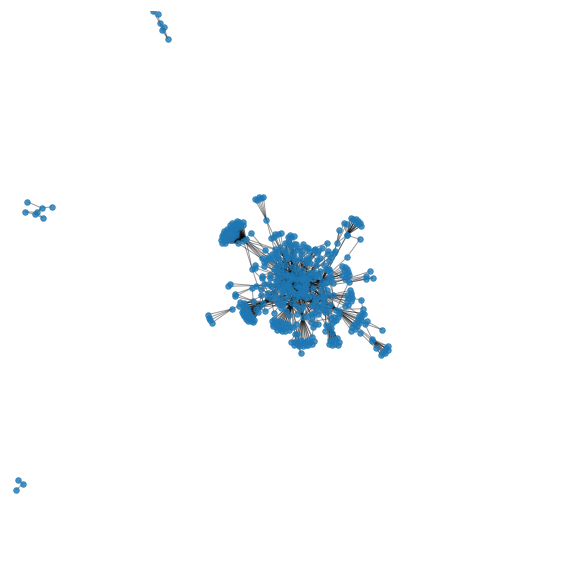

In [125]:
seed=0

G,Id2Index,Index2Id,_=makeChengfGraph('resbak/15649717377814.json')
pos=drawGraph(G,cluster=None,node_size=30,seed=seed)

440 2.325
395 2.1848101265822786
84 1.9761904761904763
67 2.029850746268657
49 2.0
33 2.0
25 2.08
311 1.9003215434083602
183 1.9398907103825136
61 1.819672131147541
42 2.0
40 2.05
122 1.7540983606557377


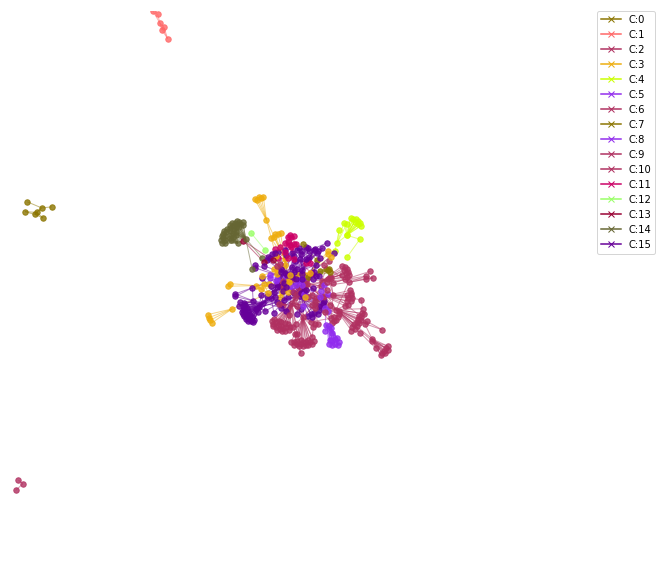

In [126]:
L=LaplacianMatrix(graph2Matrix(G,norm=False))
######################老方法###################################
# S,V=eig(L)
# K=proposalCluster(S,0.8)
# print('classes:',K)
# K=4
# labels=getCluster(K,V)
# labels=V[:,1]>0
#######################新方法##################################
labels=clusterHelper(L,complex=1.8)
pos=drawGraph(G,labels,lineWidth=1,node_size=30,seed=seed)

### 根据分类提取出子图,然后可以对子图进行rank

In [127]:
subgraphs=get_subGraph(G,labels)

聚类:0,节点数量:7,边数量(无向):10
聚类:1,节点数量:6,边数量(无向):10
聚类:2,节点数量:3,边数量(无向):3
聚类:3,节点数量:45,边数量(无向):84
聚类:4,节点数量:17,边数量(无向):28
聚类:5,节点数量:18,边数量(无向):34
聚类:6,节点数量:16,边数量(无向):21
聚类:7,节点数量:8,边数量(无向):9
聚类:8,节点数量:16,边数量(无向):32
聚类:9,节点数量:9,边数量(无向):10
聚类:10,节点数量:128,边数量(无向):207
聚类:11,节点数量:19,边数量(无向):25
聚类:12,节点数量:2,边数量(无向):1
聚类:13,节点数量:3,边数量(无向):3
聚类:14,节点数量:37,边数量(无向):45
聚类:15,节点数量:122,边数量(无向):238


In [128]:
Index2Id={x:x for x in G.nodes}

In [129]:
cluster_rank=SubGraphPageRank(subgraphs,
                              global_name_fn=Index2Id,
                              topK=-1,alpha=0.85,maxiters=300,eps=0.01)
# cluster_rank

使用稀疏表示法
使用稀疏表示法
使用稀疏表示法
使用稀疏表示法


In [130]:
##显示子图,然后观测子图的rank

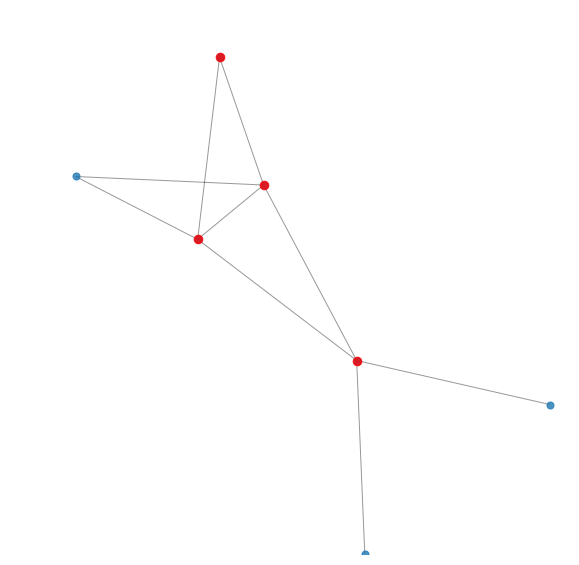

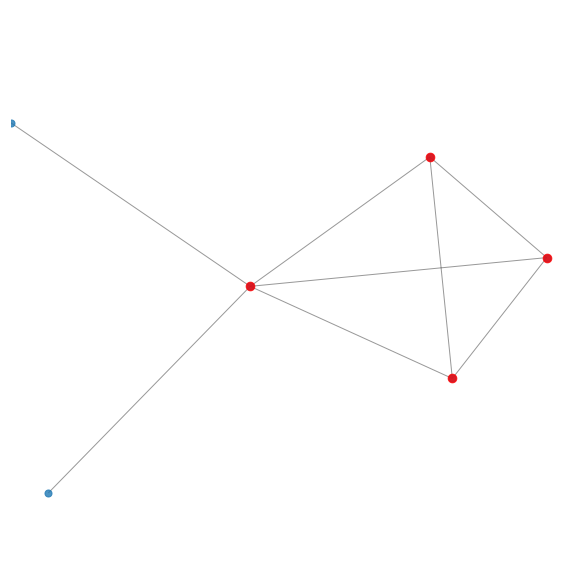

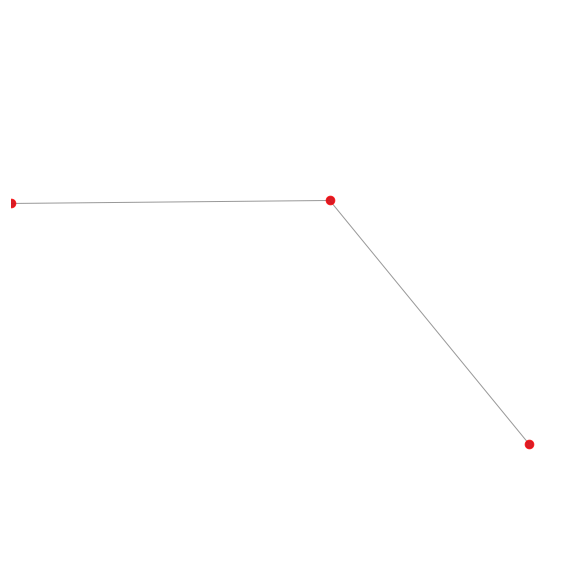

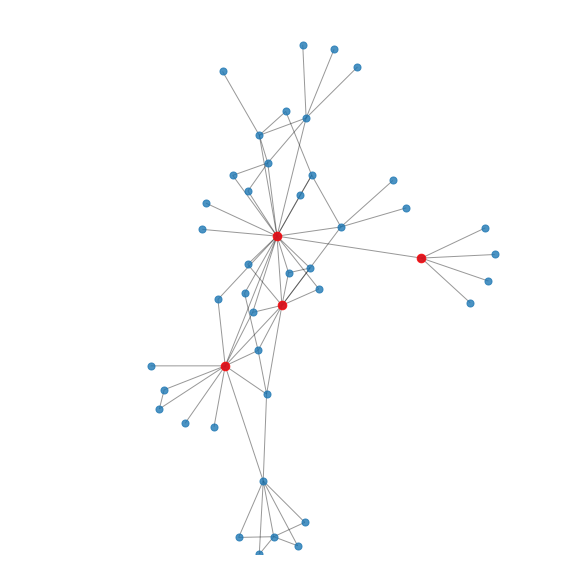

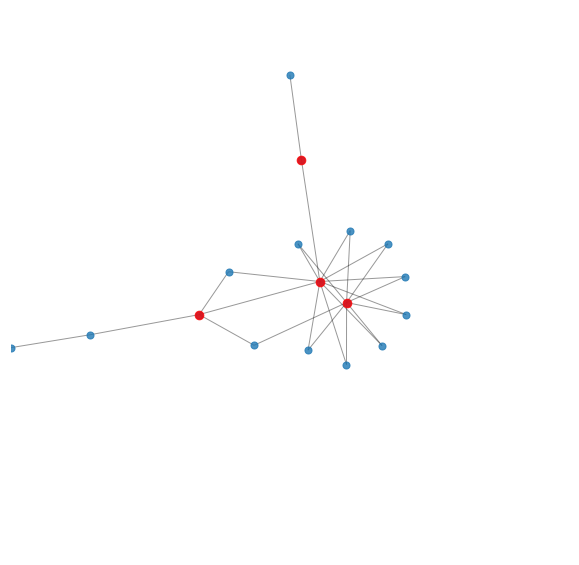

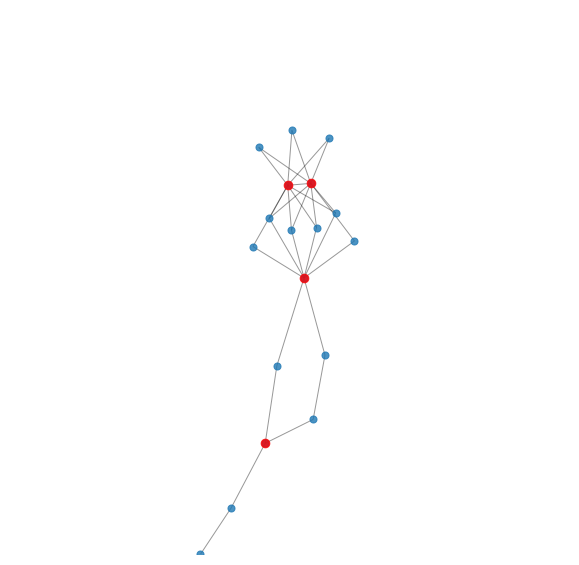

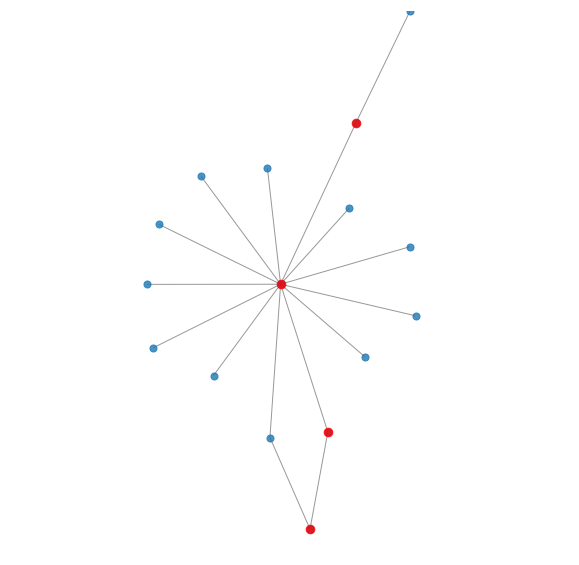

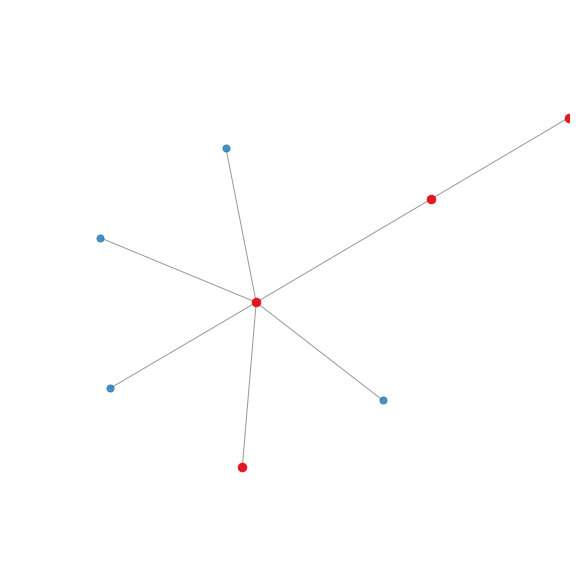

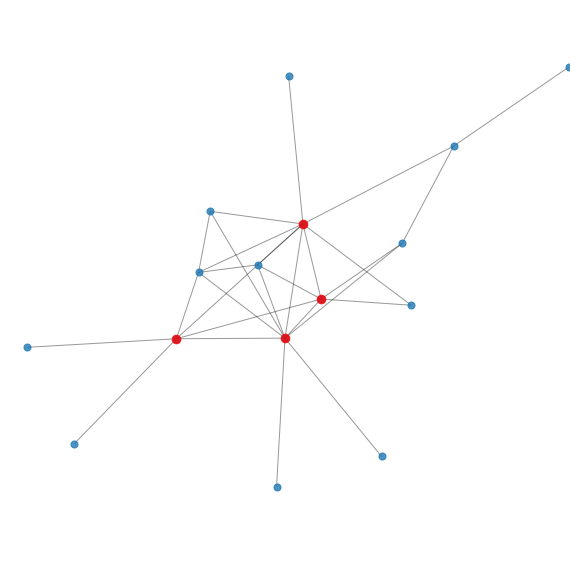

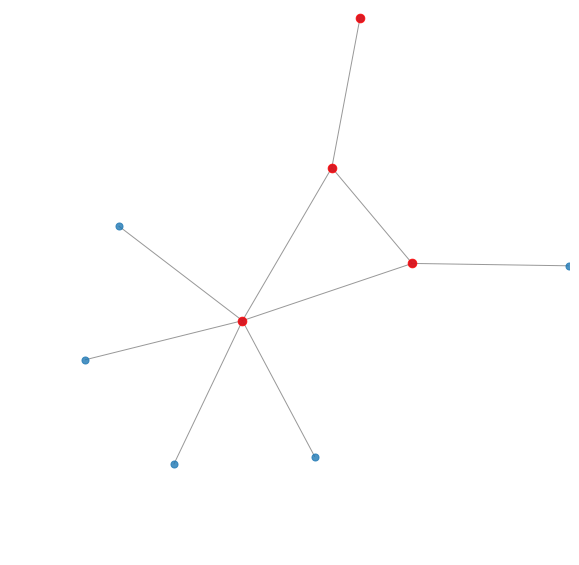

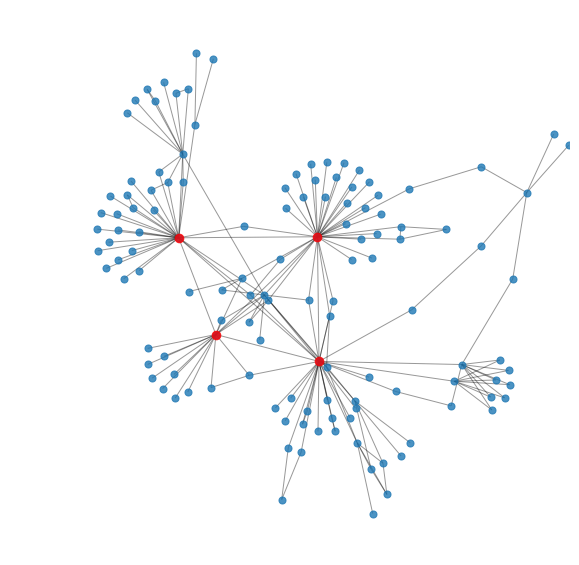

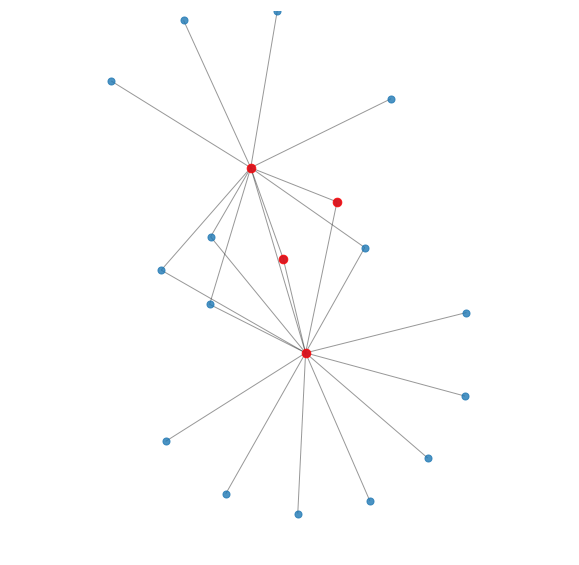

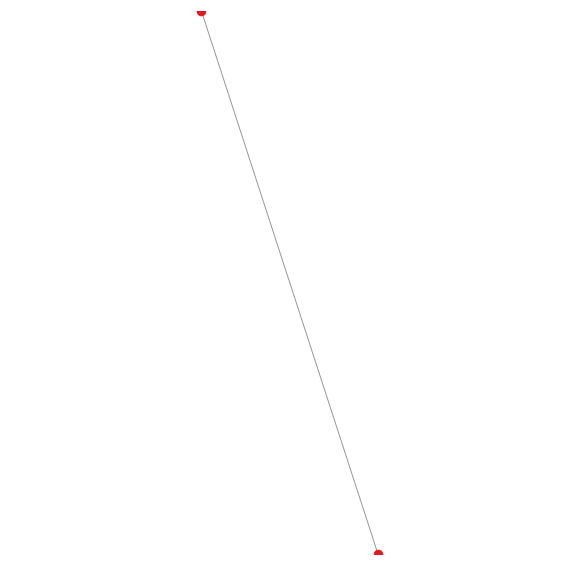

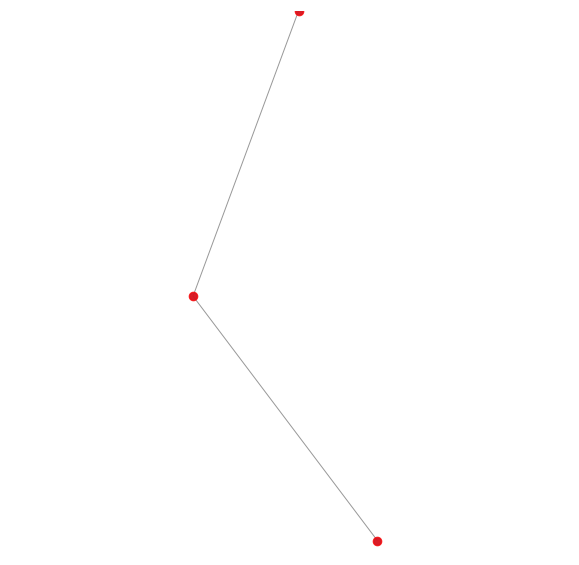

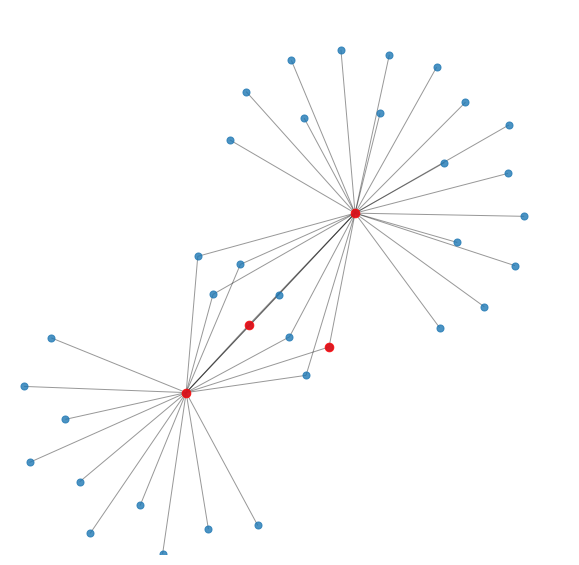

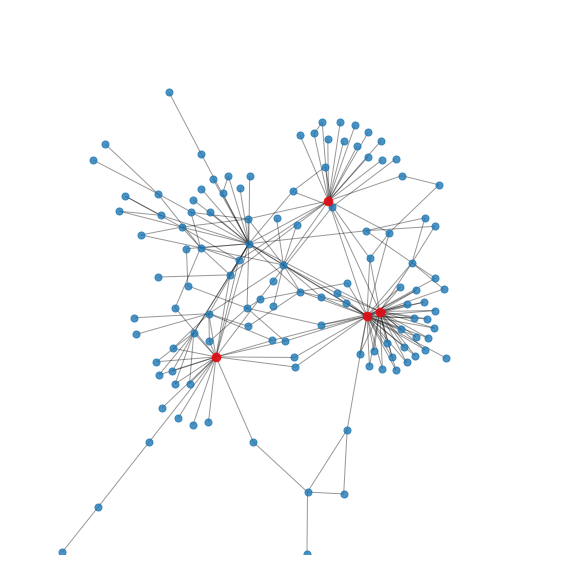

In [131]:
for clusterId in range(len(cluster_rank)):
    g=subgraphs[clusterId]['graph']
    highlight_node=cluster_rank[clusterId]['top_index'][:4]
    g_pos=drawGraph(g,node_size=50,seed=seed,highlight_node=highlight_node)

In [ ]:
MYGraph=subgraphs[0]['graph']
indexfunc=subgraphs[0]['2index']
_=drawGraph(MYGraph,node_size=30,seed=seed)
A=graph2Matrix(MYGraph,indexfunc,norm=False)
L=LaplacianMatrix(A)
S,V=eig(L)

In [ ]:
c=getCluster(2,V)
c=V[:,1]>0
cluster={}
for n in MYGraph.node:
    idx=indexfunc[n]
    cluster[n]=c[idx]
_=drawGraph(MYGraph,cluster=cluster,node_size=10,seed=seed)

In [ ]:
with open('resbak/1564383416897.json') as fs:
    d=json.load(fs)
sizes=[]
for edge in d['edges']:
    sizes.append(edge['size'])

In [ ]:
np.std(sizes)